### Imports

In [1]:
import os
import gc
import glob
import json
from collections import defaultdict
import multiprocessing as mp
from pathlib import Path
from types import SimpleNamespace
from typing import Dict, List, Optional, Tuple
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import PIL.Image as Image
from sklearn.metrics import fbeta_score
from sklearn.exceptions import UndefinedMetricWarning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as thd
from tqdm import tqdm
import pandas as pd
from PIL import Image
# Adjust the maximum image size limit
Image.MAX_IMAGE_PIXELS = None
import numpy as np
import os
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib

In [2]:
# control
crossValidation = False
finalModel = False
predict_first = True  # predicts the letering from train image 2 and 3
submit = True

In [3]:
# Define the paths of the three folders
folder_paths = [
    "/kaggle/input/vesuvius-challenge/train/1",
    #"/kaggle/input/vesuvius-challenge/train/2",
    #"/kaggle/input/vesuvius-challenge/train/3"
]
num_pixels_total = 1000

In [4]:
def generate_data_fraction(folder_path, fraction_number, num_pixels, scaler):

    # Create an empty list to store the values for each row
    df = []
    cols = []

    # Load mask.png, crop, and resize
    mask_path = os.path.join(folder_path, "mask.png")
    mask_image = Image.open(mask_path)
    mask_array = np.array(mask_image)
    cols.append('Mask')

    image_height = mask_array.shape[0]
    fraction_start = (fraction_number - 1) * num_pixels_total
    fraction_end = fraction_start + num_pixels
    print("Shape", mask_array[fraction_start:fraction_end, :].shape)
    df.append(mask_array[fraction_start:fraction_end, :].flatten())

    del mask_image, mask_array

    # Iterate over the files in the surface_volume subfolder
    surface_volume_path = os.path.join(folder_path, "surface_volume")
    surface_volume_files = sorted(os.listdir(surface_volume_path))
    for file_name in surface_volume_files:
        file_path = os.path.join(surface_volume_path, file_name)
        image = Image.open(file_path)
        image_array = np.array(image) / 65535
        cols.append(file_name.split('.')[0])
        df.append(image_array[fraction_start:fraction_end, :].flatten())

        del image_array, image

    df = pd.DataFrame(np.vstack(df).T, columns=cols)
    
    masked = df['Mask']
    
    # Select columns 20 to 45 from X_train
    df = df.iloc[:, 20:46]
    
    # Load inklabels.png, crop, and resize
    inklabels_path = os.path.join(folder_path, "inklabels.png")
    inklabels_image = Image.open(inklabels_path)
    inklabels_array = np.array(inklabels_image)
    df['labels'] = inklabels_array[fraction_start:fraction_end, :].flatten()

    del inklabels_image, inklabels_array

    # Print the shape of the dataframe
    print("initial shape", df.shape)

    # Filter out rows that start with 0 in the "Mask" column
    df = df[masked != 0]
    
    mean = df.iloc[:, :-1].mean().mean()
    std = df.iloc[:, :-1].std().mean()
    
    lower_threshold = mean - 3 * std
    upper_threshold = mean + 3 * std
    
    df.iloc[:, :-1] = df.iloc[:, :-1].clip(lower_threshold, upper_threshold)
    
    from sklearn.preprocessing import MinMaxScaler

    if scaler == None:
        # Scale X_train between 0 and 1
        scaler = MinMaxScaler(feature_range=(0, 1))
        df.iloc[:, :-1] = pd.DataFrame(scaler.fit_transform(df.iloc[:, :-1]), columns=df.iloc[:, :-1].columns)
        joblib.dump(scaler, 'scaler.pkl')
    else:
        df.iloc[:, :-1] = pd.DataFrame(scaler.transform(df.iloc[:, :-1]), columns=df.iloc[:, :-1].columns)

    # Print the shape of the dataframe
    print("final shape", df.shape)
    
    df = df.drop_duplicates()
    
    return df.iloc[:, :-1], df.iloc[:, -1], scaler


In [5]:
plot_values = False

if plot_values:

    # Iterate over the folder paths
    folder_path=folder_paths[0]

    # Load mask.png to calculate fractions
    mask_path = os.path.join(folder_path, "mask.png")
    mask_image = Image.open(mask_path)
    # Get the height and width of the image
    image_width, image_height = mask_image.size
    print(folder_path,"width:",image_width,"heigth:",image_height)
    fractions = int(np.ceil(image_height / num_pixels_total))
    num_pixels_array = np.concatenate((np.full(fractions-1, num_pixels_total), np.array([image_height - (fractions-1)*num_pixels_total])))

    print("Number of fractions:",fractions)
    del mask_image

    frac=1

    scaler=None

    print("generating X_train and y_train for",frac,"fraction")
    # Generate the first part of the data
    X_train, y_train, scaler = generate_data_fraction(folder_path,frac,num_pixels_array[frac-1],scaler)

    # Assuming X_train is your pandas DataFrame
    values = X_train.values.flatten()  # Flatten the DataFrame into a 1D array

    plt.hist(values, bins=10, range=(0, 1))  # Adjust the number of bins as needed
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of Values in X_train')
    plt.show()
    
    # Assuming X_train and y_train are your pandas DataFrames or Series
    values_0 = X_train[y_train == 0].values.flatten()
    values_1 = X_train[y_train == 1].values.flatten()

    bin_count = 10
    bin_range = (0, 1)

    hist_0, bins = np.histogram(values_0, bins=bin_count, range=bin_range)
    hist_1, _ = np.histogram(values_1, bins=bin_count, range=bin_range)

    bin_edges = bins[:-1]
    total_counts = hist_0 + hist_1
    percentage_0 = (hist_0 / total_counts) * 100
    percentage_1 = (hist_1 / total_counts) * 100

    plt.bar(bin_edges, percentage_0, width=(bin_range[1] - bin_range[0]) / bin_count, align='edge', color='blue', alpha=0.5, label='y_train = 0')
    plt.bar(bin_edges, percentage_1, width=(bin_range[1] - bin_range[0]) / bin_count, align='edge', color='green', alpha=0.5, label='y_train = 1')
    plt.xlabel('Values')
    plt.ylabel('Percentage')
    plt.title('Histogram of Values in X_train')
    plt.legend()
    plt.show()
    
    # Exclude the 'sum' column if present
    columns_to_plot = [col for col in X_train.columns if col != 'sum']

    # Calculate the mean values for each column based on target values
    means_0 = X_train.loc[y_train == 0, columns_to_plot].mean()
    means_1 = X_train.loc[y_train == 1, columns_to_plot].mean()

    # Create a list of column names for the x-axis
    x_labels = list(means_0.index)

    # Create a figure and axes for the plot
    fig, ax = plt.subplots()

    # Plot the mean values for target=0 as a line
    ax.plot(x_labels, means_0, label='Target 0', marker='o')

    # Plot the mean values for target=1 as a line
    ax.plot(x_labels, means_1, label='Target 1', marker='o')

    # Set the labels and title
    ax.set_xlabel('Columns')
    ax.set_ylabel('Mean Values')
    ax.set_title('Mean Values by Column and Target')

    # Rotate the x-axis labels if needed
    plt.xticks(rotation=90)

    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()


In [6]:
crossValidation = False

if crossValidation:

    # Hyperparameters to tune
    param_grid = {
        'boosting_type': ['gbdt'],
        'num_leaves': [150,200],
        'max_depth': [12,14],
        'learning_rate': [0.25,0.3],
        'n_estimators': [400,600],
        'subsample': [1.0],
        'colsample_bytree': [1.0]
    }
    
    scaler = None
    
    # Load mask.png to calculate fractions
    mask_path = os.path.join(folder_paths[0], "mask.png")
    mask_image = Image.open(mask_path)
    # Get the height and width of the image
    image_width, image_height = mask_image.size
    print(folder_paths[0],"width:",image_width,"heigth:",image_height)
    fractions = int(np.ceil(image_height / num_pixels_total))
    num_pixels_array = np.concatenate((np.full(fractions-1, num_pixels_total), np.array([image_height - (fractions-1)*num_pixels_total])))
    
    print("Number of fractions:",fractions)
    del mask_image
    
    print("generating X_train_first and y_train_first")
    # Generate the first half of the data
    X_train_first, y_train_first, _ = generate_data_fraction(folder_paths[0],1,num_pixels_array[1],scaler)
    
    # Split the first half data into training set and validation set
    X_train_first, X_val_first, y_train_first, y_val_first = train_test_split(
        X_train_first, y_train_first, test_size=0.2, random_state=42)
    
    # Perform hyperparameter tuning using GridSearchCV
    model = lgb.LGBMClassifier()
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', verbose=1)
    grid_search.fit(X_train_first[:3000000], y_train_first[:3000000])
    
    # Get the best hyperparameters found
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)
    
    # Create a LightGBM dataset for training the model on the first half
    train_data_first = lgb.Dataset(X_train_first, label=y_train_first)
    del X_train_first,y_train_first
    
    # Train the LightGBM model on the first half of the data using the best hyperparameters
    model = lgb.train(best_params, train_data_first, num_boost_round=100)

    # Predict on the validation set (first half)
    y_pred_val_first = model.predict(X_val_first)
    
    # Set a threshold for classification (e.g., 0.5)
    threshold = 0.4
    
    # Convert predicted probabilities to binary labels
    y_pred_binary_val_first = (y_pred_val_first >= threshold).astype(int)
    
    # Calculate the accuracy on the validation set (first half)
    accuracy_val_first = accuracy_score(y_val_first, y_pred_binary_val_first)
    print("Validation Accuracy (First Half):", accuracy_val_first)


In [7]:
finalModel = False

# Load the scaler
scaler = joblib.load('/kaggle/input/modeloutput/scaler.pkl')

if finalModel: 
    
    # Define the paths of the three folders
    final_folder_paths = [
        "/kaggle/input/vesuvius-challenge/train/1",
        #"/kaggle/input/vesuvius-challenge/train/2",
        #"/kaggle/input/vesuvius-challenge/train/3"
    ]
    
    # Define the LightGBM parameters
    params = {
        'boosting_type': 'gbdt',
        'num_leaves': 200,
        'max_depth': 12,
        'learning_rate': 0.3,
        'n_estimators': 600,
        'subsample': 1.0,
        'colsample_bytree': 1.0,
        'verbose': 1
    }
    
    # Iterate over the folder paths
    for folder_path in final_folder_paths:
        
        # Load mask.png to calculate fractions
        mask_path = os.path.join(folder_path, "mask.png")
        mask_image = Image.open(mask_path)
        # Get the height and width of the image
        image_width, image_height = mask_image.size
        print(folder_path,"width:",image_width,"heigth:",image_height)
        fractions = int(np.ceil(image_height / num_pixels_total))
        num_pixels_array = np.concatenate((np.full(fractions-1, num_pixels_total), np.array([image_height - (fractions-1)*num_pixels_total])))

        print("Number of fractions:",fractions)
        del mask_image
        
        for frac in range(1,fractions+1):
        
            print("generating X_train and y_train for",frac,"fraction")
            # Generate the first part of the data
            X_train, y_train, _ = generate_data_fraction(folder_path,frac,num_pixels_array[frac-1], scaler)

            # Split the first part data into training set and validation set
            X_train, X_val, y_train, y_val = train_test_split(
                X_train, y_train, test_size=0.2, random_state=42)

            # Create a LightGBM dataset for training the model on the first part
            train_data = lgb.Dataset(X_train, label=y_train)
            del X_train

            if '/1' in folder_path and frac==1:
                print("Start training model")
                # Train the LightGBM model on the first half of the data
                model = lgb.train(params, train_data, num_boost_round=100)
            else:
                print("Fine-tuning the model, part", frac, "file:", folder_path)
                model = lgb.train(params, train_data, num_boost_round=100, init_model=model)


            # Predict on the validation set
            y_pred_val = model.predict(X_val)
            print("y_pred_val between",np.min(y_pred_val),"and",np.max(y_pred_val))

            # Set a threshold for classification (e.g., 0.5)
            threshold = 0.5

            # Convert predicted probabilities to binary labels
            y_pred_binary_val = (y_pred_val >= threshold).astype(int)

            # Calculate the accuracy on the validation set
            accuracy_val = accuracy_score(y_val, y_pred_binary_val)
            print("Validation Accuracy of part",frac,"of file:",folder_path,":", accuracy_val)

            # Clear variables to release memory
            del X_val, y_train, y_val, train_data, y_pred_val, y_pred_binary_val

        # Save the updated model to a file
        model_file = "model_final.txt"
        model.save_model(model_file)
        print("Updated model saved.")

### Create predictions

In [8]:
def generate_data_fraction_for_submition(folder_path, fraction_number, num_pixels, scaler):
    
    # Create an empty list to store the values for each row
    df = []
    cols = []

    # Load mask.png, crop, and resize
    mask_path = os.path.join(folder_path, "mask.png")
    mask_image = Image.open(mask_path)
    mask_array = np.array(mask_image)
    cols.append('Mask')

    image_height = mask_array.shape[0]
    
    fraction_start = (fraction_number - 1) * num_pixels_total
    fraction_end = fraction_start +  num_pixels
    print("Shape", mask_array[fraction_start:fraction_end, :].shape)
    df.append(mask_array[fraction_start:fraction_end, :].flatten())

    del mask_image, mask_array
    
    # Iterate over the files in the surface_volume subfolder
    surface_volume_path = os.path.join(folder_path, "surface_volume")
    surface_volume_files = sorted(os.listdir(surface_volume_path))
    for file_name in surface_volume_files:
        if int(file_name.split('/')[-1].split('.')[0]) in range(20,46):
            file_path = os.path.join(surface_volume_path, file_name)
            image = Image.open(file_path)
            image_array = np.array(image) / 65535
            cols.append(file_name.split('.')[0])
            df.append(image_array[fraction_start:fraction_end, :].flatten())

            del image_array, image
      
    df = pd.DataFrame(np.vstack(df).T, columns=cols)
    
    # Print the shape of the dataframe
    print("initial shape", df.shape)
    
    input_features = df.drop('Mask', axis=1)
    
    mean = input_features.mean().mean()
    std = input_features.std().mean()
    
    lower_threshold = mean - 3 * std
    upper_threshold = mean + 3 * std
    
    input_features = input_features.clip(lower_threshold, upper_threshold)

    input_features = pd.DataFrame(scaler.transform(input_features), columns=input_features.columns)
    
    predictions = model.predict(input_features)
    prediction_array = np.where(df['Mask'] == 0, 0, predictions)
    
    print("prediction-array shape",prediction_array.shape)

    return prediction_array


/kaggle/input/vesuvius-challenge/test/b width: 6330 heigth: 5454
Number of fractions: 19 of image in folder /kaggle/input/vesuvius-challenge/test/b
generating predictions for fraction 1
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 2
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 3
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 4
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 5
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 6
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 7
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 8
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 9
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 10
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 11
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 12
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 13
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 14
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 15
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 16
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 17
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 18
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 19
Shape (54, 6330)
initial shape (341820, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (341820,)


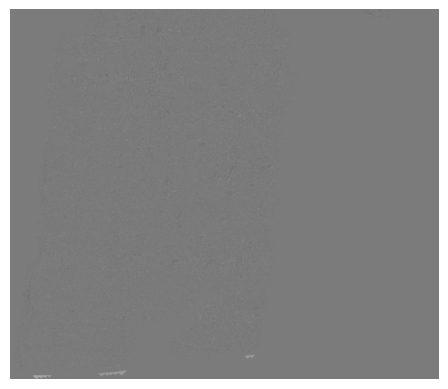

/kaggle/input/vesuvius-challenge/test/a width: 6330 heigth: 2727
Number of fractions: 10 of image in folder /kaggle/input/vesuvius-challenge/test/a
generating predictions for fraction 1
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 2
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 3
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 4
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 5
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 6
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 7
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 8
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 9
Shape (300, 6330)
initial shape (1899000, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (1899000,)
generating predictions for fraction 10
Shape (27, 6330)
initial shape (170910, 27)


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 45
Feature names seen at fit time, yet now missing:
- 19

  warnings.warn(message, FutureWarning)


prediction-array shape (170910,)


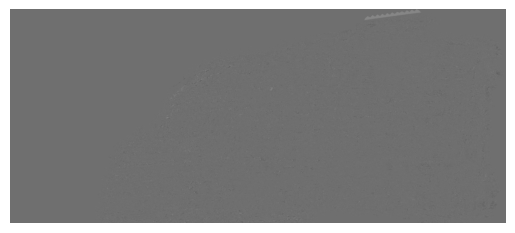

In [9]:
# Load the scaler
scaler = joblib.load('/kaggle/input/modeloutput/scaler.pkl')

predict_first = True

if predict_first:
    
    num_pixels_total = 300
    # instantiate images predicted variable
    pred_images = []
    
    # load model
    model = lgb.Booster(model_file='/kaggle/input/modeloutput/model_final.txt')
    
    # Define the paths of the three folders
    test_folder_path = "/kaggle/input/vesuvius-challenge/test"

    folder_paths = []
    for root, dirs, files in os.walk(test_folder_path):
        for dir in dirs:
            if len(os.path.join(root, dir)) <= (len(test_folder_path)+2):
                folder_paths.append(os.path.join(root, dir))
    
    predicted_images = []
    # Iterate over the folder paths
    for folder_path in folder_paths:
        
        predicted_image = None
        
        # Load mask.png to calculate fractions
        mask_path = os.path.join(folder_path, "mask.png")
        mask_image = Image.open(mask_path)
        # Get the height and width of the image
        image_width, image_height = mask_image.size
        print(folder_path,"width:",image_width,"heigth:",image_height)
        fractions = int(np.ceil(image_height / num_pixels_total))
        num_pixels_array = np.concatenate((np.full(fractions-1, num_pixels_total), np.array([image_height - (fractions-1)*num_pixels_total])))

        print("Number of fractions:",fractions,"of image in folder",folder_path)
        del mask_image
        
        for frac in range(1,fractions+1):
        
            print("generating predictions for fraction",frac)
            # Generate the first part of the data
            prediction = generate_data_fraction_for_submition(folder_path,frac,num_pixels_array[frac-1],scaler)
            if predicted_image is None:
                # If it's the first prediction, initialize the predicted image array
                predicted_image = prediction
            else:
                # Concatenate the prediction with the existing predicted image array
                predicted_image = np.concatenate((predicted_image, prediction))     
                
            # Save the predicted_image array
            # output_file = "predicted_image_"+folder_path.split('/')[-1]+"_part_"+str(frac)+".npy"
            # np.save(output_file, predicted_image)
        
        # Save the predicted_image as a PNG file
        output_file = "predicted_image_"+folder_path.split('/')[-1]+".npy"
        predicted_image_2d = predicted_image.reshape((image_height,image_width))
        np.save(output_file, predicted_image_2d)
        
        # Display the image
        plt.imshow(predicted_image_2d, cmap='gray')
        plt.axis('off')
        plt.show()
        
        predicted_images.append(predicted_image)

In [10]:
def rle(output):
    flat_img = np.where(output > 0.4, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))

In [11]:
from collections import defaultdict

if submit:
        
    test_folders = sorted([f for f in os.listdir(test_folder_path) if os.path.isdir(os.path.join(test_folder_path, f))])
    submission = defaultdict(list)
    for fragment_id, fragment_name in enumerate(test_folders):
        submission["Id"].append(fragment_name)
        submission["Predicted"].append(rle(predicted_images[fragment_id]))

    pd.DataFrame.from_dict(submission).to_csv("/kaggle/working/submission.csv", index=False)